## Vehicle/Nonvehicle Test Model
- Mainly looking to start a model based on the previous flowers model provided by TensorFlow's website as a tutorial for image processing and reocgnition.
- Should be noted that I am using the kaggle dataset for training compared to the Stanford one we will be identifying in the future. 
- Kaggle dataset found at https://www.kaggle.com/brsdincer/vehicle-detection-image-set
- There are other models found but I am primarily following the outline of the previous flower tutorial found in this repository.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
data_dir = "data/"
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

17760


In [9]:
# Can't seem to view images directly using PIL. Possibly an issue with format of pngs vs jpgs.

nonvehicles = list(data_dir.glob("nonvehicles/*"))
PIL.Image.open(str(nonvehicles[1]))

IndexError: list index out of range

In [10]:
vehicles = list(data_dir.glob("vehicles/*"))

In [11]:
# May need to mess with batch sizing and sizing of the images with the larger amount of vehicles.
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17760 files belonging to 2 classes.
Using 12432 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17760 files belonging to 2 classes.
Using 5328 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['non-vehicles', 'vehicles']


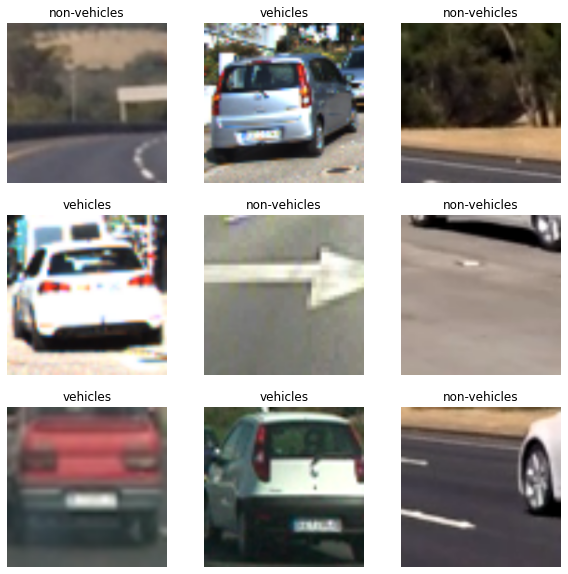

In [15]:
# Images are still imported correctly with little issue and pyplot has little issue updating them as such.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Original Model
- Images are not changed in any way from the original data set
- Only 10 epochs are used for this
- More than likely the validation split is too large as the program takes over 20 minutes to sort through all the images in a single run
- Seems to be overfitting the model honestly with the high accuracy rate
- The graphs are fairly different from the flower model with the largest difference being in the validation accuracy being so insanely high

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07507627 1.0


In [1]:
# Unsure what the exact layers do here still. Will need more research into what each layer is doing to manipulate it to be
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

NameError: name 'class_names' is not defined

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
389/389 [==============================] - 126s 322ms/step - loss: 0.1501 - accuracy: 0.9394 - val_loss: 0.0536 - val_accuracy: 0.9822
Epoch 2/10
389/389 [==============================] - 121s 310ms/step - loss: 0.0530 - accuracy: 0.9821 - val_loss: 0.0761 - val_accuracy: 0.9748
Epoch 3/10
389/389 [==============================] - 121s 312ms/step - loss: 0.0443 - accuracy: 0.9861 - val_loss: 0.0282 - val_accuracy: 0.9912
Epoch 4/10
389/389 [==============================] - 122s 314ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0332 - val_accuracy: 0.9895
Epoch 5/10
389/389 [==============================] - 127s 327ms/step - loss: 0.0302 - accuracy: 0.9897 - val_loss: 0.0458 - val_accuracy: 0.9876
Epoch 6/10
389/389 [==============================] - 126s 325ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0243 - val_accuracy: 0.9927
Epoch 7/10
389/389 [==============================] - 136s 349ms/step - loss: 0.0159 - accuracy: 0.9940 - val_loss: 0.0366 -

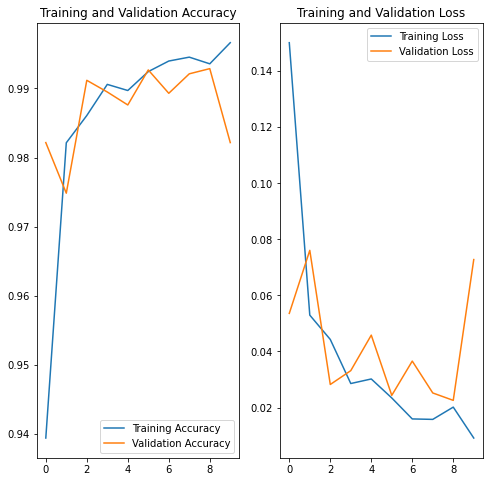

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Secondary Model
- First step was to augment the data by rotating the images in random ways to make certain the model wasn't becoming too used to the exact orientation of certain images.
- On top of this the model is now up to 15 epochs and the model takes even longer to complete.
- A single run of the model for validation ends up with over 2.5 minutes per epoch instead of the 2 minutes that we saw previously.
- Likely not an issue for the sake of making the model but does make it harder to test in a vaccuum due to the length of any single trial run. 
- Same issue arose for the validation accuracy in the graphing of the data afterwards. Need to double check if and how I am overfitting the training data honestly. 

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

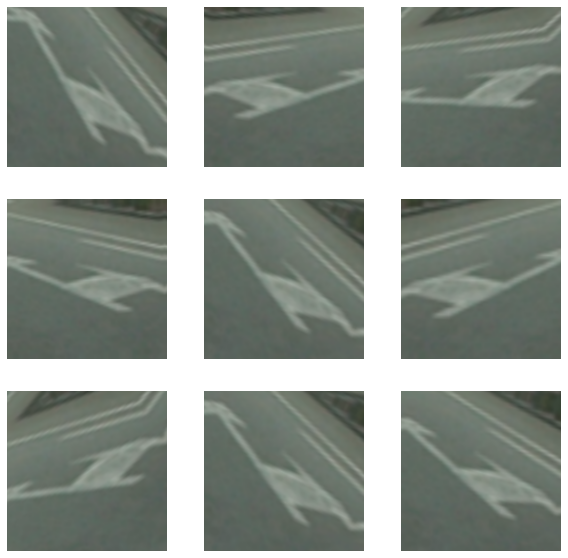

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
389/389 [==============================] - 159s 405ms/step - loss: 0.2009 - accuracy: 0.9120 - val_loss: 0.0658 - val_accuracy: 0.9779
Epoch 2/15
389/389 [==============================] - 157s 403ms/step - loss: 0.0740 - accuracy: 0.9748 - val_loss: 0.0472 - val_accuracy: 0.9829
Epoch 3/15
389/389 [==============================] - 159s 410ms/step - loss: 0.0589 - accuracy: 0.9776 - val_loss: 0.0357 - val_accuracy: 0.9880
Epoch 4/15
389/389 [==============================] - 155s 399ms/step - loss: 0.0554 - accuracy: 0.9808 - val_loss: 0.0584 - val_accuracy: 0.9788
Epoch 5/15
389/389 [==============================] - 151s 387ms/step - loss: 0.0454 - accuracy: 0.9836 - val_loss: 0.0302 - val_accuracy: 0.9897
Epoch 6/15
389/389 [==============================] - 152s 392ms/step - loss: 0.0412 - accuracy: 0.9863 - val_loss: 0.0281 - val_accuracy: 0.9895
Epoch 7/15
389/389 [==============================] - 150s 387ms/step - loss: 0.0321 - accuracy: 0.9889 - val_loss: 0.0595 -

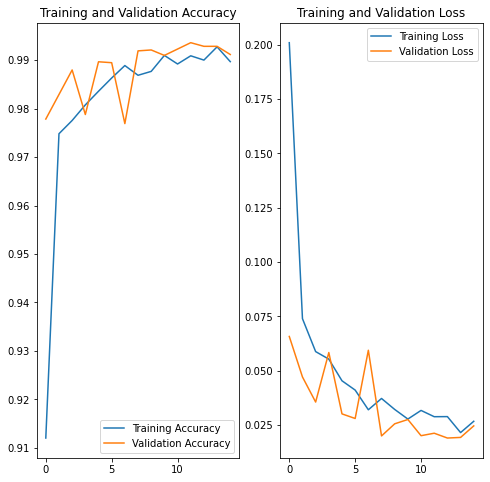

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()